### Calculo las pendientes de los perfiles de densidad superficial estelar en bines de edad
#### Los perfiles en bines equalnumber radial

In [6]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import density

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    
    print ('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit2, = np.where(rn < rgal )
    
    age_ = age[limit2]
#     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    
    nb = 14

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)
    
    # color_range = np.linspace(4,10,nb)
    # norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    # cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    age_med = np.ones(nb)*np.nan
    slope = np.ones(nb)*np.nan
    k=0
    for i in rango:
        
        agelim, = np.where((age_>i) & (age_<i+delta))
        
        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        mass = mstr[limit2][agelim]
    
        nbin = 20
        den = density.surf_density(R,mass,nbin)

        age_med[k] = i+delta/2

        mask = ~np.isnan(den[0])
        
        if mask.sum()<(nbin-3):
            continue
            
        slope[k] = np.polyfit(den[1][mask],np.log10(den[0][mask]),1)[0]

        k += 1
        # print('age=',age_med, 'm=', slope)

    data = np.ndarray([nb,2])
    data[:,0]= age_med
    data[:,1]= slope
    np.savetxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'.dat', data, fmt=('%12.8f','%12.8f'))

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


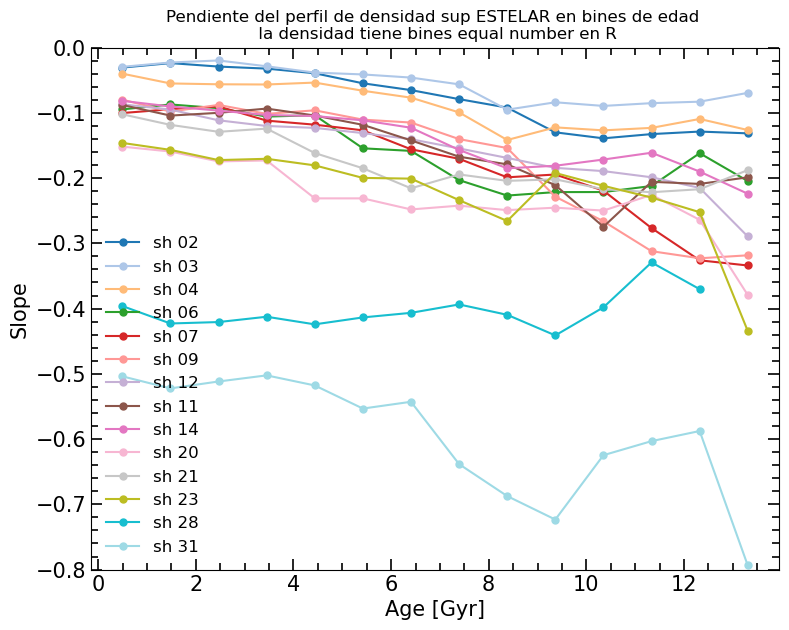

In [14]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.tab20(np.linspace(0, 1, 14))

for j in range(14):
    data = np.loadtxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'.dat')

    age   = data[:,0]
    slope = data[:,1]

    

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    
    ax.plot(age,slope,'-o', label='sh '+Id, ms=5,color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.8,0.)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup ESTELAR en bines de edad \n la densidad tiene bines equal number en R')
ax.legend(fontsize=12,frameon=False)



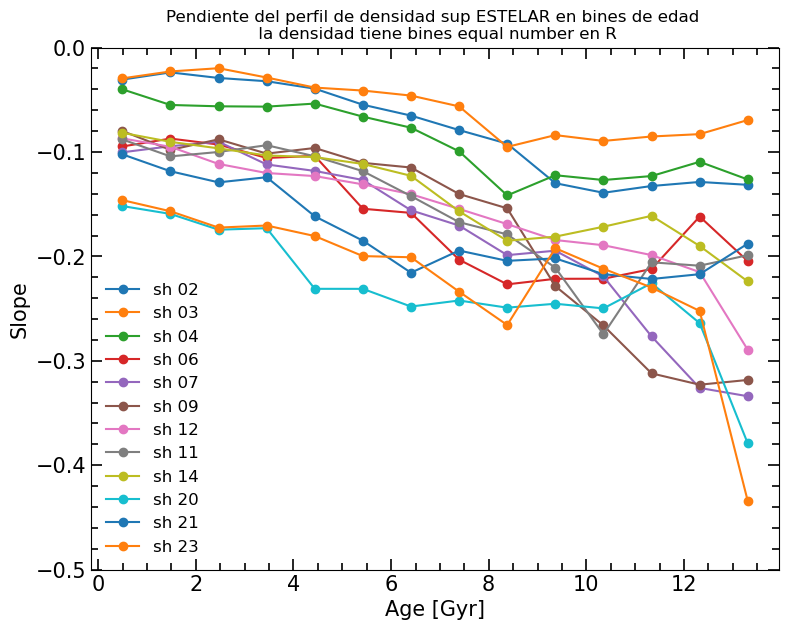

In [8]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(12):
    data = np.loadtxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'.dat')

    age   = data[:,0]
    slope = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.5,0.)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup ESTELAR en bines de edad \n la densidad tiene bines equal number en R')
ax.legend(fontsize=12,frameon=False)



### Calculo las pendientes de los perfiles de densidad superficial estelar en bines de edad
#### Los perfiles en bines logaritmicos radiales

In [21]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import density

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    
    print ('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit2, = np.where(rn < rgal )
    
    age_ = age[limit2]
#     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    
    nb = 14

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)
    
    age_med = np.ones(nb)+np.nan
    slope = np.ones(nb)*np.nan
    k=0
    for i in rango:
        
        agelim, = np.where((age_>i) & (age_<i+delta))
        
        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        mass = mstr[limit2][agelim]
    
        nbin = 20
        den = density.surf_density_log(R,mass,nbin)

        age_med[k] = i+delta/2

        mask = ~np.isnan(np.log10(den[0]))
        
        if mask.sum()<(nbin-3):
            continue
        
        slope[k] = np.polyfit(den[1][mask],np.log10(den[0])[mask],1)[0]

        # print('age=',age_med[k], 'm=', slope[k])
        k += 1
        

    data = np.ndarray([nb,2])
    data[:,0]= age_med
    data[:,1]= slope
    np.savetxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'_logbin.dat', data, fmt=('%12.8f','%12.8f'))

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


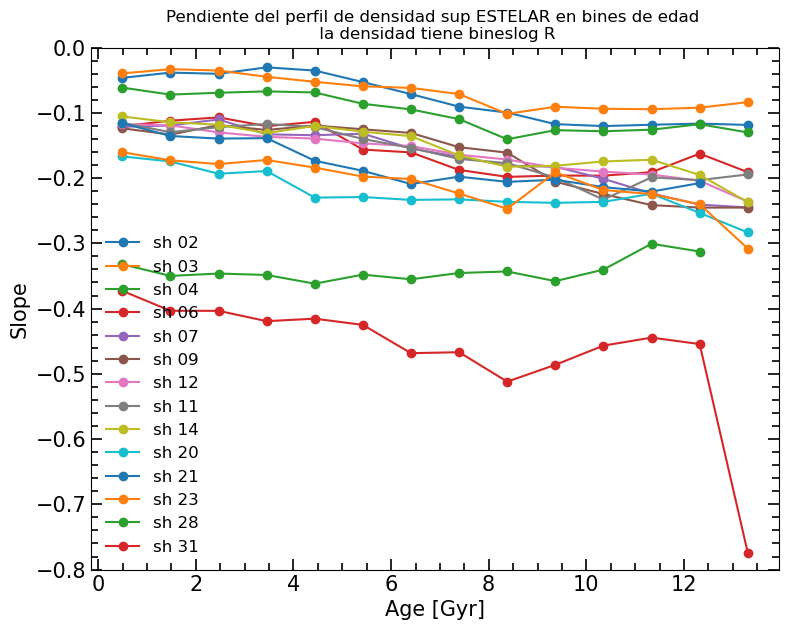

In [27]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(14):
    data = np.loadtxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age   = data[:,0]
    slope = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.8,0.)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup ESTELAR en bines de edad \n la densidad tiene bineslog R')
ax.legend(fontsize=12,frameon=False)



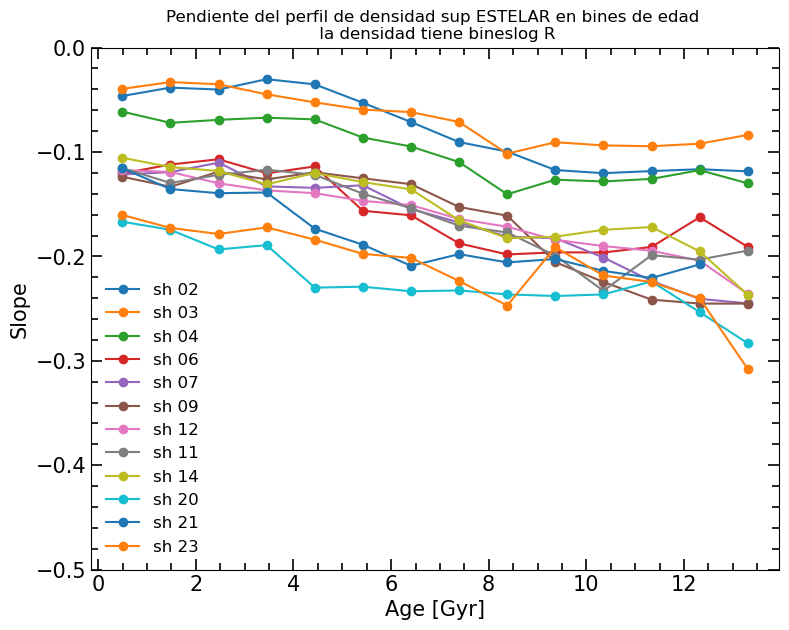

In [28]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(12):
    data = np.loadtxt('../_data/densup_profile/slope_perfil_densup_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age   = data[:,0]
    slope = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.5,0.)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup ESTELAR en bines de edad \n la densidad tiene bineslog R')
ax.legend(fontsize=12,frameon=False)



### Calculo las pendientes de los perfiles de densidad superficial del gas para todos los tiempos
#### Los perfiles en bines logaritmicos radiales

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
R200 = np.loadtxt('../_data/my_halos.dat')[:,2]
rgal=0.15*R200
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

ages = T.max() - T
# mask,  = np.where((ages >= 4) & (ages <=10))

for j in range(14):
    
    Id = ''
    for aux in list(str('%d'%shID[j]))[-2:]:
        Id += aux
        
      
    SDP_ = np.loadtxt('../_data/gas_surfden/gas_surfden_log_prof_sh_'+str('%d'%shID[j])+'.dat')
    med = SDP_[:,0]
    SDP = SDP_[:,1]
    snap = SDP_[:,2]

    print(shID[j])

    aux = int(len(s)/14)
    rango = np.arange(0,len(s),aux)

    age_med = np.ones(len(rango))*np.nan
    slope = np.ones(len(rango))*np.nan
    k=0
    for i in rango:
        select, = np.where(snap == s[i])
        
        if (len(select)==0):
            continue

        mask = ~np.isnan(np.log10(SDP[select]))
        
        if mask.sum()<(len(SDP[select])-3):
            continue
            
        age_med[k] = ages[i] 
        slope[k] = np.polyfit(med[select][mask],np.log10(SDP[select])[mask],1)[0]

        k += 1

    data = np.ndarray([len(rango),2])
    data[:,0]= age_med
    data[:,1]= slope
    np.savetxt('../_data/densup_profile/slope_perfil_densup_GAS_sh_'+str('%d'%shID[j])+'_logbin.dat', data, fmt=('%12.8f','%12.8f'))
        
 

127000000000002.0
127000000000003.0
127000000000004.0
127000000000006.0
127000000000007.0
127000000000009.0
127000000000012.0
127000000000011.0
127000000000014.0
127000000000020.0
127000000000021.0
127000000000023.0
127000000000028.0
127000000000031.0


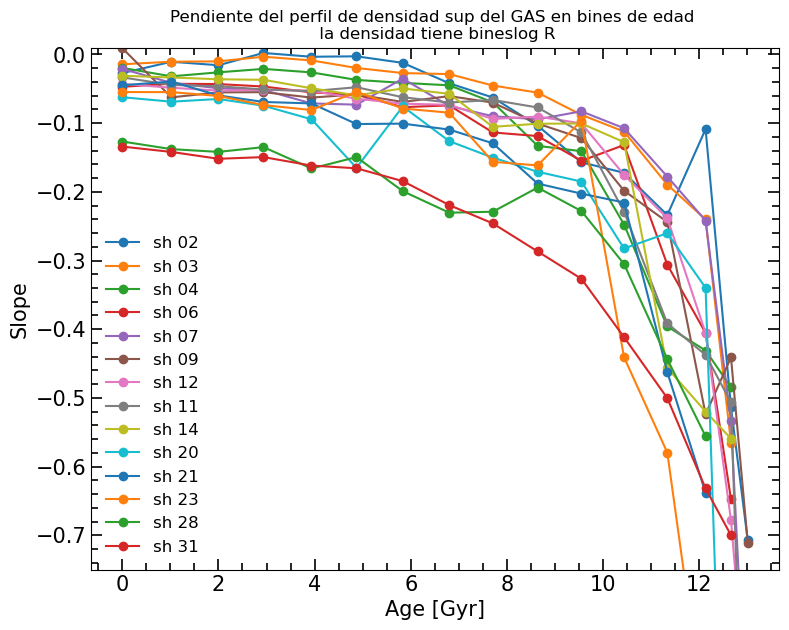

In [10]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(14):
    data = np.loadtxt('../_data/densup_profile/slope_perfil_densup_GAS_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age   = data[:,0]
    slope = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.75,0.01)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup del GAS en bines de edad \n la densidad tiene bineslog R')
ax.legend(fontsize=12,frameon=False)



### Calculo las pendientes de los perfiles de densidad superficial en r50 en función de la edad.


In [1]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import density
from scipy.interpolate import interp1d

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    
    print ('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    print('r50=',r50)
    
    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit2, = np.where(rn < rgal )
    
    age_ = age[limit2]
#     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    
    nb = 14

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)
    
    age_med = np.zeros(nb)
    slope = np.zeros(nb)
    k=0
    h=0.1
    for i in rango:
        
        agelim, = np.where((age_>i) & (age_<i+delta))
        
        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        mass = mstr[limit2][agelim]
    
        nbin = 20
        den = density.surf_density_log(R,mass,nbin)

        mask = ~np.isnan(den[0])
        
        age_med[k] = i+delta/2

        diff = abs(den[1][mask]-r50)
        near = diff.argmin()

        aux_vector_x = np.array([den[1][mask][near-1],den[1][mask][near],den[1][mask][near+1]])
        aux_vector_y = np.array([np.log10(den[0][mask])[near-1],np.log10(den[0][mask])[near],np.log10(den[0][mask])[near+1]])
        slope[k] = np.polyfit(aux_vector_x,aux_vector_y,1)[0]

        # print('age=',age_med[k], 'm=', slope[k])
        k += 1
        

    data = np.ndarray([nb,2])
    data[:,0]= age_med
    data[:,1]= slope
    np.savetxt('../_data/densup_profile/slope_r50_perfil_densup_sh_'+str('%d'%ID[j])+'_logbin.dat', data, fmt=('%12.8f','%12.8f'))

subhalo_127000000000002
r50= 10.748496
subhalo_127000000000003
r50= 13.477973
subhalo_127000000000004
r50= 9.724034
subhalo_127000000000006
r50= 5.276335
subhalo_127000000000007
r50= 4.6233883
subhalo_127000000000009
r50= 5.1774135
subhalo_127000000000012
r50= 5.7153077
subhalo_127000000000011
r50= 5.450668
subhalo_127000000000014
r50= 6.0566792
subhalo_127000000000020
r50= 3.773638
subhalo_127000000000021
r50= 5.069559
subhalo_127000000000023
r50= 4.417653
subhalo_127000000000028
r50= 1.8141063
subhalo_127000000000031
r50= 1.5487609


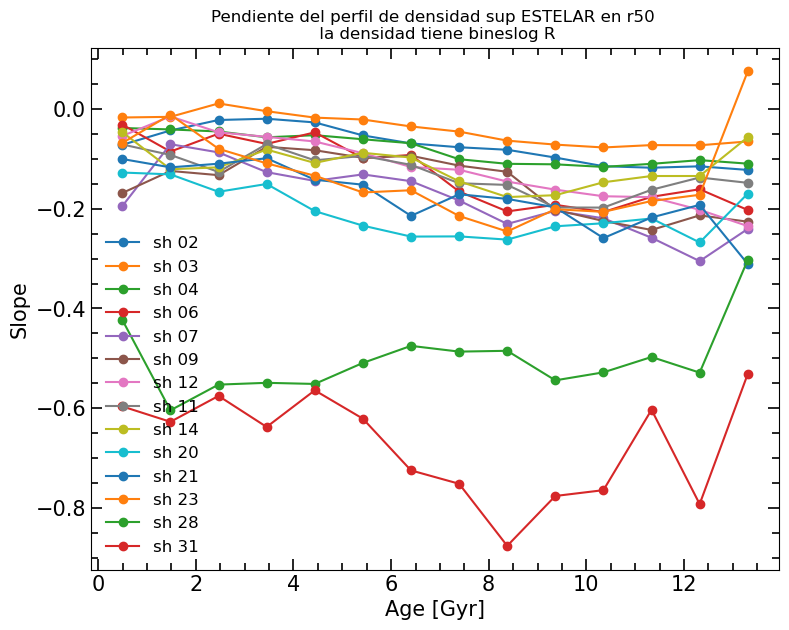

In [3]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(14):
    data = np.loadtxt('../_data/densup_profile/slope_r50_perfil_densup_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age   = data[:,0]
    slope = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
# ax.set_ylim(-0.175,0.01)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup ESTELAR en r50 \n la densidad tiene bineslog R')
ax.legend(fontsize=12,frameon=False)



### Calculo las pendientes de los perfiles de densidad superficial del gas para todos los tiempos en r50
#### Los perfiles en bines logaritmicos radiales

In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import metallicity_profile as metp
import z50
import density
from scipy.interpolate import interp1d

ID = np.loadtxt('../_data/my_halos.dat')[:,0]
tiempos = np.loadtxt('../_data/time.dat')
s = tiempos[:,0]
T = tiempos[:,3]
edades = T.max() - T

path = '/store/erebos/omarioni/_simulations/snap_'


for j in range(0,14):
   
    print('sh '+str('%d'%shID[j])) 

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    r_50 = np.ones(96)*np.nan

    
    for i in range(96):

        snap = h5py.File(path + str('%03d'%s[i])+ '/subhalo_'+str('%d'%shID[j])+'.h5py', 'r')
        
    
        if np.mod(i,10)==0:
            print(s[i])
        
        aexp = snap['/Time'][()]
        h    = snap['/h'][()]
        Om_L = snap['/Omega_Lambda'][()]
        Om_M = snap['/Omega_0'][()]
        Rvir = snap['/R200'][()]

        pstr = snap['/Str/Coordinates'][()]
        mstr = snap['/Str/Masses'][()]
        vstr = snap['/Str/Velocities'][()]
        sft  = snap['/Str/FormationTime'][()]
        
        pgas = snap['/Gas/Coordinates'][()]
        mgas = snap['/Gas/Masses'][()]
        met  = snap['/Gas/Metallicity'][()]
        

        amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
        
        if len(amask)==0:
            continue
            
        ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
        age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

        FeH_ = met[:,8]/met[:,0]
        FeH  = FeH_/0.0127

        xstr = pstr[amask,0]*aexp/h
        ystr = pstr[amask,1]*aexp/h
        zstr = pstr[amask,2]*aexp/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = pgas[:,0]*aexp/h
        ygas = pgas[:,1]*aexp/h
        zgas = pgas[:,2]*aexp/h

        v_x = vstr[amask,0] *np.sqrt(aexp)
        v_y = vstr[amask,1] *np.sqrt(aexp)
        v_z = vstr[amask,2] *np.sqrt(aexp)

        #----------------------masas----------------------------
        mstr = mstr[amask]*1e10/h
        mgas = mgas*1e10/h

        rgal = 0.15*Rvir*aexp/h
        limit, = np.where(rstr < rgal)
        
        if len(limit)==1 or len(limit)==0:
            continue
            
        rsort = np.argsort(rstr[limit])
        Mc = np.cumsum(mstr[limit][rsort])
        Mgal = Mc[-1]
        limit50, = np.where(Mc < Mgal/2)
        
        if len(limit50)==1 or len(limit50)==0:
            continue
            
        r_50[i] = rstr[limit][rsort][limit50][-1]

    data = np.ndarray([96,2])
    data[:,0] = s
    data[:,1] = r_50
    np.savetxt('../_data/r50_time/r50_sh'+str('%s'%Id)+'.dat', data, fmt=('%d','%12.8f'))



In [45]:
import matplotlib.pyplot as plta
import numpy as np
import matplotlib as mpl

ID = np.loadtxt('../_data/my_halos.dat')[:,0]
R200 = np.loadtxt('../_data/my_halos.dat')[:,2]
rgal=0.15*R200
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]



ages = T.max() - T
# mask,  = np.where((ages >= 4) & (ages <=10))


for j in range(14):
    
    Id = ''
    for aux in list(str('%d'%shID[j]))[-2:]:
        Id += aux
        
    r50 = np.loadtxt('../_data/r50_time/r50_sh'+str('%s'%Id)+'.dat')[:,1]
    
    SDP_ = np.loadtxt('../_data/gas_surfden/gas_surfden_log_prof_sh_'+str('%d'%shID[j])+'.dat')
    med = SDP_[:,0]
    SDP = SDP_[:,1]
    snap = SDP_[:,2]
    
    print(ID[j])

    rango = np.arange(0,len(s),3)

    age_med = np.ones(len(rango))*np.nan
    slope = np.ones(len(rango))*np.nan
    k=0
    
    for i in rango:
        select, = np.where(snap == s[i])
        
        if (len(select)==0):
            continue
            
        age_med[k] = ages[i] 

        mask = ~np.isnan(SDP[select])

        diff = abs(med[select][mask]-r50[i])
        near = diff.argmin()

        aux_vector_x = np.array([med[select][mask][near-1],med[select][mask][near],med[select][mask][near+1]])
        aux_vector_y = np.array([np.log10(SDP[select][mask])[near-1],
                                 np.log10(SDP[select][mask])[near],
                                 np.log10(SDP[select][mask])[near+1]])
        slope[k] = np.polyfit(aux_vector_x,aux_vector_y,1)[0]

        k += 1

    data = np.ndarray([len(rango),2])
    data[:,0]= age_med
    data[:,1]= slope
    np.savetxt('../_data/densup_profile/slope_r50_perfil_densup_GAS_sh'+str('%s'%Id)+'_logbin.dat', data, fmt=('%12.8f','%12.8f'))
        
 

127000000000002.0
127000000000003.0
127000000000004.0
127000000000006.0
127000000000007.0
127000000000009.0
127000000000012.0
127000000000011.0
127000000000014.0
127000000000020.0
127000000000021.0
127000000000023.0
127000000000028.0
127000000000031.0


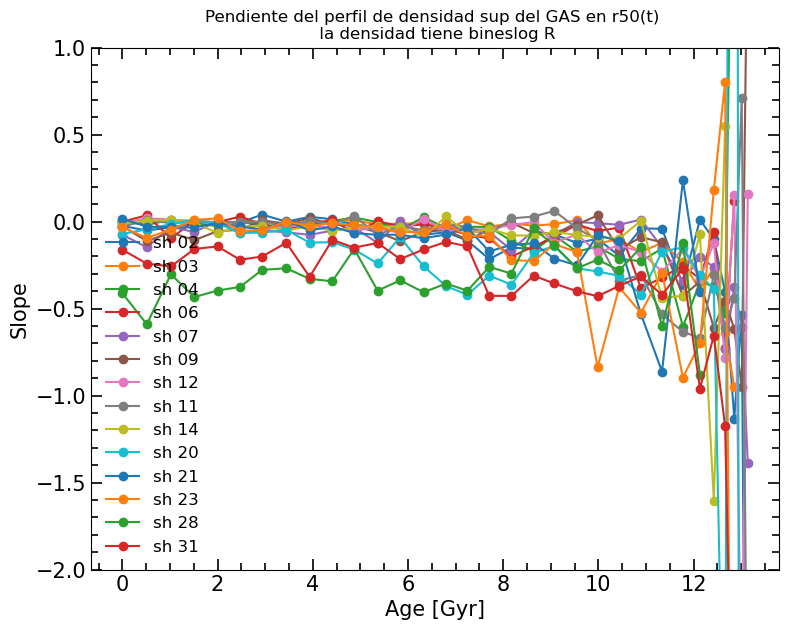

In [50]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

for j in range(14):

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/densup_profile/slope_r50_perfil_densup_GAS_sh'+str('%s'%Id)+'_logbin.dat')

    age   = data[:,0]
    slope = data[:,1]

    ax.plot(age,slope,'-o', label='sh '+Id)
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-2,1)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de densidad sup del GAS en r50(t) \n la densidad tiene bineslog R')
ax.legend(fontsize=12,frameon=False)

